### Fetch the data and construct the data frames

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CONFIRMED

df_confirmed = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

df_confirmed.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
df_confirmed = df_confirmed.groupby(['Country/Region']).sum()
df_confirmed.columns = pd.to_datetime(df_confirmed.columns)

df_confirmed_daily = df_confirmed - df_confirmed.shift(1, axis=1, fill_value=0)
df_confirmed_daily_moving = df_confirmed_daily.rolling(window=7, axis=1).mean()

# DEATHS

df_deaths = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

df_deaths.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
df_deaths = df_deaths.groupby(['Country/Region']).sum()
df_deaths.columns = pd.to_datetime(df_deaths.columns)

df_deaths_daily = df_deaths - df_deaths.shift(1, axis=1, fill_value=0)
df_deaths_daily_moving = df_deaths_daily.rolling(window=7, axis=1).mean()

# RECOVERED

df_recovered = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

df_recovered.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
df_recovered = df_recovered.groupby(['Country/Region']).sum()
df_recovered.columns = pd.to_datetime(df_recovered.columns)

df_recovered_daily = df_recovered - df_recovered.shift(1, axis=1, fill_value=0)
df_recovered_daily_moving = df_recovered_daily.rolling(window=7, axis=1).mean()

### Let's plot the data

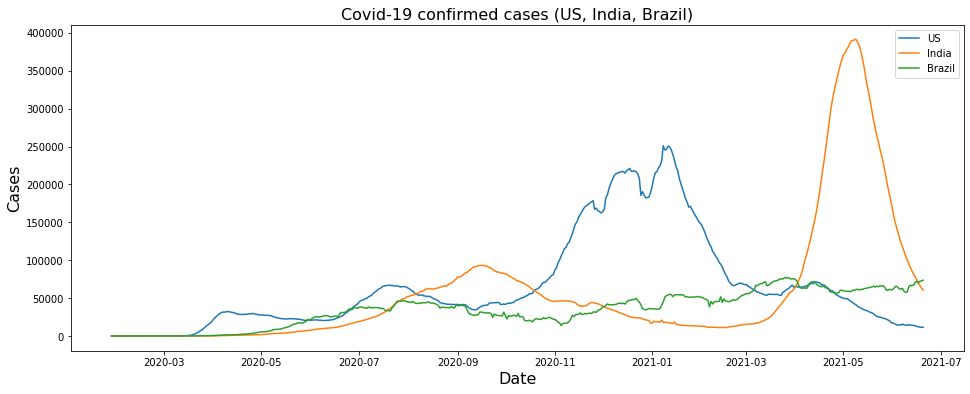

In [2]:
plt.figure(figsize=(16, 6))

plt.xlabel('Date', fontsize=16)
plt.ylabel('Cases', fontsize=16)
plt.title('Covid-19 confirmed cases (US, India, Brazil)', fontsize=16)

plt.plot(df_confirmed_daily_moving.loc['US'])
plt.plot(df_confirmed_daily_moving.loc['India'])
plt.plot(df_confirmed_daily_moving.loc['Brazil'])

plt.legend(['US', 'India', 'Brazil'])

plt.show()

### Preprocessing Stage

In [14]:
country = 'US'
nfeatures = 1
nsteps = 7

feature_1 = df_confirmed_daily.loc[country]

dataset = np.column_stack([feature_1])

data_len = len(dataset[:, 0])
train_len = int(0.8 * data_len)
test_len = data_len - train_len

train_data = dataset[:train_len, :]
test_data = dataset[train_len:, :]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_x = np.array([train_data[i - nsteps:i, :] for i in range(nsteps, train_len)])
train_y = np.array([train_data[i, 0] for i in range(nsteps, train_len)])

test_x = np.array([test_data[i - nsteps:i, :] for i in range(nsteps, test_len)])
test_y = np.array([test_data[i, 0] for i in range(nsteps, test_len)])

### Training Stage

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(units=50, input_shape=(nsteps, nfeatures), return_sequences=True),
    LSTM(units=50),
    Dense(units=25),
    Dense(units=nfeatures)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x=train_x, y=train_y, batch_size=1, epochs=5)

predictions = model.predict(test_x)
predictions = scaler.inverse_transform(predictions)

Epoch 1/5
405/405 [==============================] - 4s 5ms/step - loss: 0.0087
Epoch 2/5
405/405 [==============================] - 2s 5ms/step - loss: 0.0047
Epoch 3/5
405/405 [==============================] - 2s 5ms/step - loss: 0.0049
Epoch 4/5
405/405 [==============================] - 2s 5ms/step - loss: 0.0044
Epoch 5/5
405/405 [==============================] - 2s 5ms/step - loss: 0.0049


### Plotting of the predictions

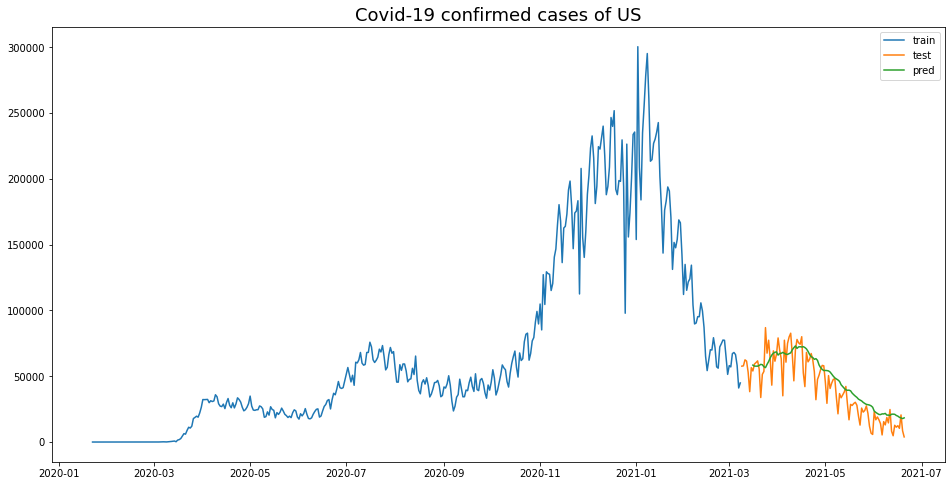

In [19]:
plt.figure(figsize=(16, 8))

plt.title(f'Covid-19 confirmed cases of {country}', fontsize=18)

time_series = feature_1
train_time_series = time_series.iloc[0:train_len]
test_time_series = time_series.iloc[train_len:]
pred_time_series = pd.Series(data=predictions[:, 0], index=test_time_series.index[nsteps:])

plt.plot(train_time_series)
plt.plot(test_time_series)
plt.plot(pred_time_series)

plt.legend(['train', 'test', 'pred'])

plt.show()

### Prediction of tomorrow

In [13]:
print(f'Prediction of tomorrow is {int(predictions[-1, 0])}')

Prediction of tomorrow is 18371
